[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_dense_layer.ipynb)

When `tf-keras-vis` is not installed in your environment, please comment out and run the cell below.

In [1]:
# !pip install --upgrade tf-keras-vis tensorflow matplotlib

# Visualizing Dense layer using ActivationMaximization

### Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2
 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
 
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
 
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

In this notebook, we use VGG16 model, however if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
 
# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a specific output category

### Define a function to modify the model

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Here, we create and use `ReplaceToLinear` instance.

In [4]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
 
replace2linear = ReplaceToLinear()
 
# Instead of using ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, however the process may take a while.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization
 
activation_maximization = ActivationMaximization(model,
                                                 model_modifier=replace2linear,
                                                 clone=True)

### Define Score function

You MUST create `Score` instance or define `score function` that returns arbitrary category value. Here, our socre function returns the value corresponding to No.20 (Ouzel) of imangenet.

In [6]:
from tf_keras_vis.utils.scores import CategoricalScore
 
# 20 is the imagenet index corresponding to Ouzel.
score = CategoricalScore(20)
 
# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refer to the output of the model,
    # so, in this case, `output` shape is `(1, 1000)` i.e., (samples, classes).
    return output[:, 20]

### Visualize

ActivationMaximization will maximize the output of the score function. Here, as a result, we will get a visualized image that maximizes the model output corresponding to the No.20 (Ouzel) of imagenet.

200/200 [==============================] - 9s 39ms/step - Score: 228.4386 - TotalVariation2D: 17.8522 - Norm: 36.6915


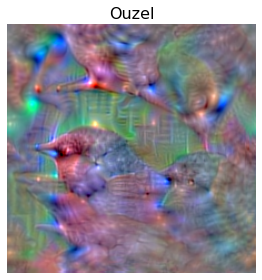

CPU times: user 8.77 s, sys: 477 ms, total: 9.25 s
Wall time: 9.19 s


In [7]:
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
 
# Generate maximized activation
activations = activation_maximization(score,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('Ouzel', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## Visualizing specific output categories

Then, let's visualize multiple categories at once!

### Define Score function

You MUST create `Score` instance or define `score function` that returns arbitrary category values. Here, our socre function returns the values corresponding to No.1 (Goldfish), No.294 (Bear) and No.413 (Assault rifle) of imagenet.

In [8]:
from tf_keras_vis.utils.scores import CategoricalScore
 
image_titles = ['Goldfish', 'Bear', 'Assault rifle']
scores = CategoricalScore([1, 294, 413])
 
# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refer to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0, 1], output[0, 294], output[0, 413])

### Create Seed Input values

And then, you MUST create `seed_input` value. In default, when visualizing a specific output category, tf-keras-vis automatically generates `seed_input` to visualize a image for each model input. When visualizing multiple images, you MUST manually create `seed_input`.

In [9]:
# Create `seed_input` whose shape is (samples, height, width, channels).
 
seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

200/200 [==============================] - 15s 72ms/step - Score: 319.9390 - TotalVariation2D: 19.0078 - Norm: 37.0567


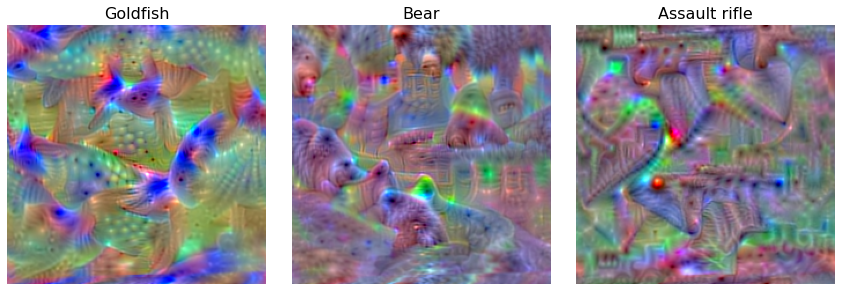

CPU times: user 14.8 s, sys: 459 ms, total: 15.2 s
Wall time: 15.3 s


In [10]:
%%time
 
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
from tf_keras_vis.activation_maximization.callbacks import Progress, PrintLogger
  
# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()